In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.api as sm
import seaborn as sns

from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [2]:
dataset = pd.read_csv("50_Startups.csv")

In [3]:
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
dataset.dropna()
dataset = dataset._get_numeric_data()

In [5]:
dataset.head()

,R&D Spend,Administration,Marketing Spend,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [6]:
y = dataset['Profit']

In [7]:
dataset.drop(['Profit'],inplace=True, axis=1)
X = dataset

In [8]:
X.shape

(50, 3)



### Assumptions :
1. There exists a linear and additive relationship between dependent (DV) and independent variables (IV). By linear, it means that the change in DV by 1 unit change in IV is constant. By additive, it refers to the effect of X on Y is independent of other variables.
2. There must be no correlation among independent variables. Presence of correlation in independent variables lead to Multicollinearity. If variables are correlated, it becomes extremely difficult for the model to determine the true effect of IVs on DV.
3. The error terms must possess constant variance. Absence of constant variance leads to heteroskedestacity.
4. The error terms must be uncorrelated i.e. error at ∈t must not indicate the at error at ∈t+1. Presence of correlation in error terms is known as Autocorrelation. It drastically affects the regression coefficients and standard error values since they are based on the assumption of uncorrelated error terms.
5. The dependent variable and the error terms must possess a normal distribution.

In [9]:
mod = sm.OLS(y,X)

In [10]:
res = mod.fit()

In [11]:
# Normalised residual
model_norm_residuals = res.get_influence().resid_studentized_internal

In [12]:
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

In [13]:
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

In [14]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Profit   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1232.
Date:                Sat, 07 Mar 2020   Prob (F-statistic):                    1.17e-44
Time:                        00:17:49   Log-Likelihood:                         -545.82
No. Observations:                  50   AIC:                                      1098.
Df Residuals:                      47   BIC:                                      1103.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
R&D Spend           0.7180      0.065     11.047      0.000       0.587       0.849
Administration      0.3277      0.031     10.458      0.000       0.265       0.391
Marketing Spend     0.0822      0.022      3.733      0.001       0.038       0.126
==============================================================================
Omnibus:                        0.665   Durbin-Watson:                   1.361
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                          -0.126   Prob(JB):                        0.688
Kurtosis:                       2.456   Cond. No.                         9.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking Autocorrelation


#### 1. Durbin Watson statistics : This test is used to check autocorrelation. Its value lies between 0 and 4. A DW=2 value shows no autocorrelation. However, a value between 0 < DW < 2 implies positive autocorrelation, while 2 < DW < 4 implies negative autocorrelation.

As we can see above value of DW Statistics = 1.361,

Hence, We can say there is a positive autocorrelation.

## Checking Multicollenarity

#### 1. Variance Inflation Factor (VIF) - This metric is used to check multicollinearity. VIF <=4 implies no multicollinearity but VIF >=10 suggests high multicollinearity. Alternatively, you can also look at the tolerance (1/VIF) value to determine correlation in IVs. In addition, you can also create a correlation matrix to determine collinear variables.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [16]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [17]:
vif.round(1)

,VIF Factor,features
0,8.4,R&D Spend
1,4.0,Administration
2,7.6,Marketing Spend


1. Administration - no multicollinearity
2. R&D Spend - has multicollinearity
3. Marketing Spend - has multicollinearity

#### 2. Condition number:

In [18]:
np.linalg.cond(res.model.exog)

9.763850121049316

## Checking Heteroskedasticity


#### 1. Breusch-Pagan / Cook Weisberg Test - This test is used to determine presence of heteroskedasticity. If you find p < 0.05, you reject the null hypothesis and infer that heteroskedasticity is present.

In [19]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 18.759153482600766),
 ('p-value', 8.443093109769504e-05),
 ('f-value', 9.407344464787942),
 ('f p-value', 5.5747031547773474e-05)]

 p > 0.05, Hence we cannot reject the null hypothesis. Heteroskedasticity is NOT present.

#### 2. Goldfeld-Quandt test

In [20]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(res.resid, res.model.exog)
lzip(name, test)

[('F statistic', 1.6805149688897918), ('p-value', 0.11564010292741458)]

#### 3. Residual vs. Fitted Values Plot 

In [21]:
# model values
model_fitted_y = res.fittedvalues

# model residuals
model_residuals = res.resid

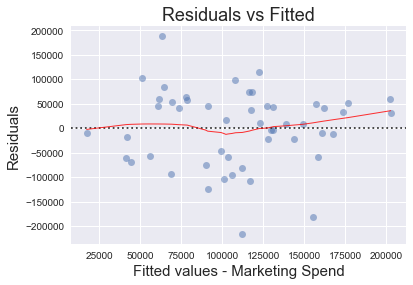

In [22]:

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, X['Marketing Spend'], data=dataset,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values - Marketing Spend')
plot_lm_1.axes[0].set_ylabel('Residuals');

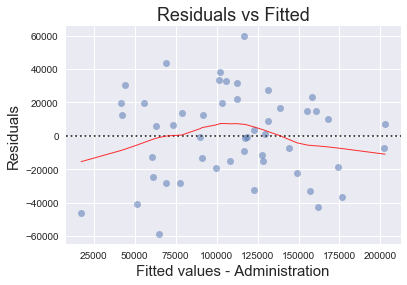

In [23]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, X['Administration'], data=dataset,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values - Administration')
plot_lm_1.axes[0].set_ylabel('Residuals');

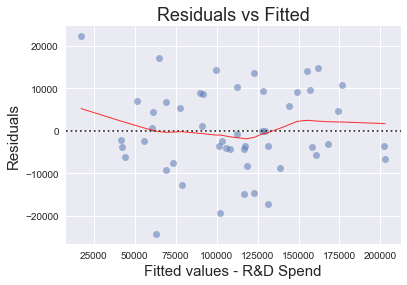

In [24]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, X['R&D Spend'], data=dataset,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values - R&D Spend')
plot_lm_1.axes[0].set_ylabel('Residuals');

There is no funnel shape. Hence, we can conclude the Heteroskedasticity is not present.

#### 4. Scale Location Plot

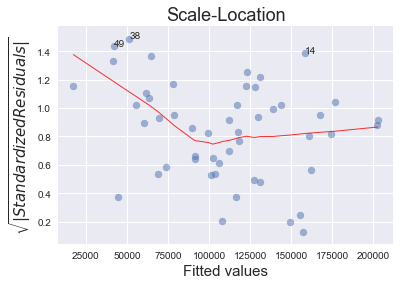

In [25]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));

## Checking Linearity

#### Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct:

In [26]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(res)
lzip(name, test)

[('t value', 2.6659193274548825), ('p value', 0.010558055928020475)]

## Checking Normality of the residuals

#### 1. Jarque-Bera test:

In [27]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
lzip(name, test)

[('Jarque-Bera', 0.7491291198557931),
 ('Chi^2 two-tail prob.', 0.6875886172513355),
 ('Skew', -0.12576140402653982),
 ('Kurtosis', 2.455648776468837)]

#### 2. Omni test:

In [28]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(res.resid)
lzip(name, test)

[('Chi^2', 0.6652492222031255), ('Two-tail probability', 0.7170393122381258)]

#### 3. Normality Q-Q Plot

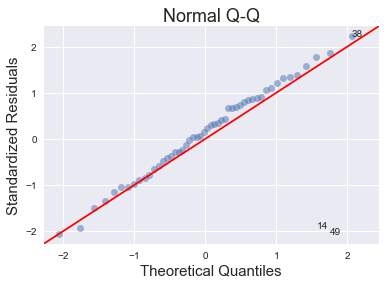

In [29]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

Linearity is present

### Influence plots

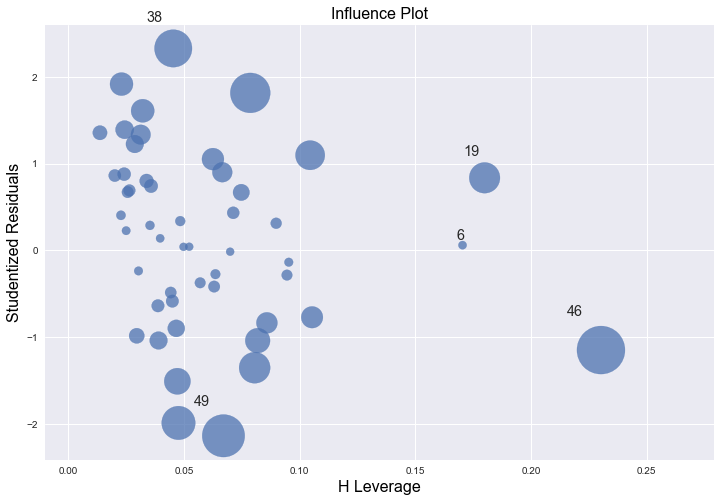

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(res, ax=ax, criterion="cooks")

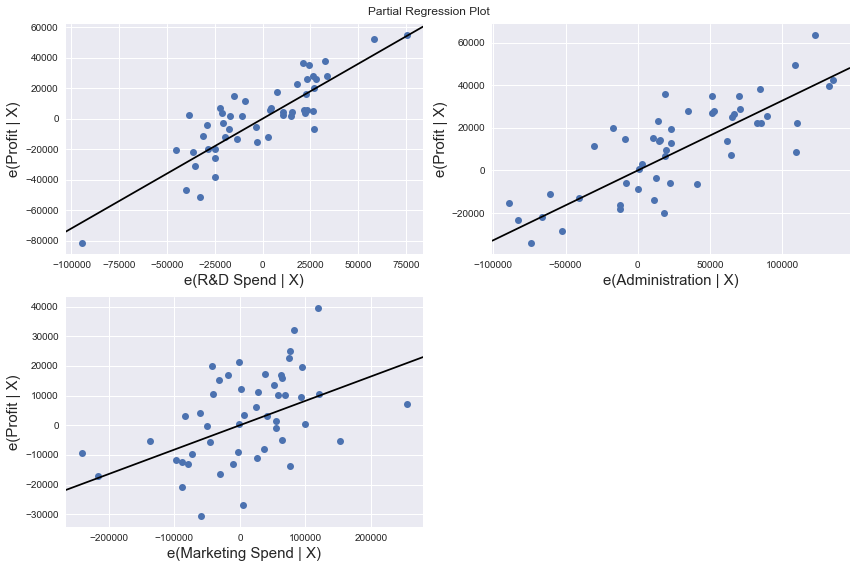

In [31]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)

### How to solve the Assumption problem if they exists ?

1. Non-linerity : Transform the "Independent Variables" using sqrt, log, square etc.
2. Heteroskedasticity : Transform the "Dependent Variable" using sqrt, log, square etc.
3. Multicollinearity : 
                        A. Use correlation matrix to check correleated variables and remove one of highly correlated value amongst them.
                        B. Use Penalized Regression methords such as lasso, ridge or elasti net etc.
4. You can do variable selection based on p values. If a variable shows p value > 0.05, we can remove that variable from model since at p> 0.05, we'll always fail to reject null hypothesis.


## How to check if my model is performing better than before ?

1. R Square (Coefficient of Determination) - As explained above, this metric explains the percentage of variance explained by covariates in the model. It ranges between 0 and 1. Usually, higher values are desirable but it rests on the data quality and domain. For example, if the data is noisy, you'd be happy to accept a model at low R² values. But it's a good practice to consider adjusted R² than R² to determine model fit.

2. Adjusted R Square : The problem with R² is that it keeps on increasing as you increase the number of variables, regardless of the fact that the new variable is actually adding new information to the model. To overcome that, we use adjusted R² which doesn't increase (stays same or decrease) unless the newly added variable is truly useful.

3. F-Statistics : It evaluates the overall significance of the model. The ration of explaind variance by model by unexplained variance. "It compares the full model with an intercept only model". It's value lies in between zero and any arbitrary high number. Naturally, Higher the F-Statistics number -> better the model.

4. RMSE / MSE / MAE : These are error matrics. The lower the number the better the model.
    A. MSE : Mean Square Error. Aplify the impact of outlier on model accuracy.
            For example, if actual y is 10 and predictive y is 40, the resultant MSE would be (40-10)² = 900.
    B. MAE : Mean Absolute Error. It is robust against outliers.
            For example, if actual y is 10 and predictive y is 40, the resultant MAE would be (40-10) = 30.
    C. RMSE : Root Mean Square Error. It's interpreted as on an average how far an average is from Zero. It nullifies the imapact of MSE and provide the results in original units as data. Here, the resultant RMSE would be √(30-10)² = 20. Don't get baffled when you see the same value of MAE and RMSE. Usually, we calculate these numbers after summing overall values (actual - predicted) from the data.
